<a href="https://colab.research.google.com/github/unofficial-Jona/ACML/blob/main/bounding_box_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     |████████████████████████████████| 308 kB 5.1 MB/s 
     |████████████████████████████████| 80 kB 6.9 MB/s 
     |████████████████████████████████| 209 kB 44.6 MB/s 
     |████████████████████████████████| 75 kB 3.5 MB/s 
     |████████████████████████████████| 49 kB 4.9 MB/s 
     |████████████████████████████████| 112 kB 51.6 MB/s 
     |████████████████████████████████| 149 kB 48.3 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=5ec58502e8604d6e64202a39dd2f62f27a240e875f753c1bcae429ef405f876f
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Input, UpSampling2D, Reshape, Cropping2D
from tensorflow.keras.applications import VGG16
from keras.models import Sequential, Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import patches
import os
import optuna

# create the dataset

In [3]:
pre_string = 'drive/MyDrive/hippo data/'
X_valid = np.load(pre_string + 'valid.npz')['x']/255
y_valid = np.load(pre_string + 'valid.npz')['y']
X_test = np.load(pre_string + 'test.npz')['x']/255
y_test = np.load(pre_string + 'test.npz')['y']
X_train = np.load(pre_string + 'train.npz')['x']/255
y_train = np.load(pre_string + 'train.npz')['y']

In [4]:
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [5]:
batch_size = 256
shuffle_buffer_size = 100

train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size)
valid_data = valid_data.shuffle(shuffle_buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

# first model

In [21]:
model = Sequential([
    Input((400,150,1)),
    Conv2D(8, kernel_size=(5,5), padding='valid', activation = 'relu'),
    Conv2D(16, kernel_size=(3,3), padding='valid', activation = 'relu'),
    Conv2D(8, kernel_size=(5,5), padding='valid', activation = 'relu'),
    MaxPool2D((4,4)),
    Conv2D(16, kernel_size=(5,5), padding='valid', activation = 'relu'),
    Conv2D(32, kernel_size=(3,3), padding='valid', activation = 'relu'),
    Conv2D(16, kernel_size=(5,5), padding='valid', activation = 'relu'),
    MaxPool2D((2,2)),
    Conv2D(64, kernel_size=(3,3), padding='valid', activation = 'relu'),
    # Conv2D(128, kernel_size=(5,5), padding='valid', activation = 'relu'),
    # Conv2D(32, kernel_size=(3,3), padding='valid', activation = 'relu'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(4, activation='sigmoid')
])

opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
model.compile(optimizer = opt, loss='mae', metrics=['cosine_similarity', 'mse', 'mae'])
model.summary()

NameError: ignored

In [ ]:
model.fit(train_data, validation_data=valid_data, epochs=70, verbose=1)
model.evaluate(test_data)
predictions = model.predict(test_data)
predictions

In [ ]:
y_test

Rectangle(xy=(74.1031, 148.838), width=29.9929, height=48.163, angle=0) Rectangle(xy=(84.3024, 137.96), width=20.7988, height=53.3681, angle=0)


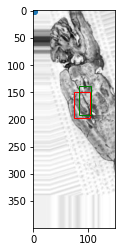

In [49]:
def plot_result(img_idx = 0):
  img = X_test[img_idx]
  org_coord = y_test[img_idx]
  pred_coord = predictions[img_idx]

  org_bbx = patches.Rectangle((org_coord[0] * 150, org_coord[1] * 400), (org_coord[2]-org_coord[0]) * 150, (org_coord[3]-org_coord[1]) * 400, linewidth=1, edgecolor = 'r', facecolor='none')
  pred_bbx = patches.Rectangle((pred_coord[0] * 150, pred_coord[1] * 400), (pred_coord[2]-pred_coord[0]) * 150, (pred_coord[3]-pred_coord[1]) * 400,  linewidth=1, edgecolor = 'g', facecolor='none')

  fig, axs = plt.subplots()
  axs.imshow(img, cmap='gray')
  axs.add_patch(org_bbx)
  axs.scatter([org_coord[0], org_coord[2]], [org_coord[1], org_coord[3]])
  axs.add_patch(pred_bbx)
  print(org_bbx, pred_bbx)

plot_result(15)

## study to optimize model architecture

In [ ]:
def objective(trial):
  model = Sequential()

  model.add(Input((400,150,1)))
  # first convolutional block
  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_1_1', [8,16]),
      kernel_size = trial.suggest_categorical('kernel_size_1_1', [3,5,7]),
      activation = trial.suggest_categorical('activation_1_1', ['relu']),
      padding= trial.suggest_categorical('padding_1_1', ['same', 'valid'])))
  
  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_1_2', [8,16,32]),
      kernel_size = trial.suggest_categorical('kernel_size_1_2', [3,5,7]),
      activation = trial.suggest_categorical('activation_1_2', ['relu']),
      padding= trial.suggest_categorical('padding_1_2', ['same', 'valid'])))
  
  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_1_3', [8,16,32]),
      kernel_size = trial.suggest_categorical('kernel_size_1_3', [3,5,7]),
      activation = trial.suggest_categorical('activation_1_3', ['relu']),
      padding= trial.suggest_categorical('padding_1_3', ['same', 'valid'])))

  # first MaxPool 
  model.add(MaxPool2D(
      pool_size = trial.suggest_categorical('pool_size_1', [2,4])))
  
  # second convolutional block
  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_2_1', [16, 32]),
      kernel_size = trial.suggest_categorical('kernel_size_2_1', [3,5,7]),
      activation = trial.suggest_categorical('activation_2_1', ['relu']),
      padding= trial.suggest_categorical('padding_2_1', ['same', 'valid'])))

  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_2_2', [16, 32, 64]),
      kernel_size = trial.suggest_categorical('kernel_size_2_2', [3,5,7]),
      activation = trial.suggest_categorical('activation_2_2', ['relu']),
      padding= trial.suggest_categorical('padding_2_2', ['same', 'valid'])))

  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_2_3', [16, 32, 64]),
      kernel_size = trial.suggest_categorical('kernel_size_2_3', [3,5,7]),
      activation = trial.suggest_categorical('activation_2_3', ['relu']),
      padding= trial.suggest_categorical('padding_2_3', ['same', 'valid'])))
  # second MaxPool
  model.add(MaxPool2D(
      pool_size = (2,2)))

  # third convolutional block
  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_3_1', [32, 64,128]),
      kernel_size = trial.suggest_categorical('kernel_size_3_1', [3,5,7]),
      activation = trial.suggest_categorical('activation_3_1', ['relu']),
      padding= trial.suggest_categorical('padding_3_1', ['same', 'valid'])))

  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_3_2', [32, 64,128]),
      kernel_size = trial.suggest_categorical('kernel_size_3_2', [3,5,7]),
      activation = trial.suggest_categorical('activation_3_2', ['relu']),
      padding = trial.suggest_categorical('padding_3_2', ['same', 'valid'])))

  model.add(
    Conv2D(
      filters = trial.suggest_categorical('filters_3_3', [32, 64,128]),
      kernel_size = trial.suggest_categorical('kernel_size_3_3', [3,5,7]),
      activation = trial.suggest_categorical('activation_3_3', ['relu']),
      padding= trial.suggest_categorical('padding_3_3', ['valid'])))
  # third MaxPool
  model.add(MaxPool2D(
      pool_size = trial.suggest_categorical('pool_size_3', [2,4])))  

  model.add(Flatten())
  # Dense 1
  model.add(Dense(
      units = trial.suggest_categorical('units_1', [64,128]),
      activation = trial.suggest_categorical('activation_d1', ['relu'])))
  # Dense 2
  model.add(Dense(
      units = trial.suggest_categorical('units_2', [32,64]),
      activation = trial.suggest_categorical('activation_d2', ['relu'])))
  # Dense 3
  model.add(Dense(
      units = trial.suggest_categorical('units_3', [8,16]),
      activation = trial.suggest_categorical('activation_d3', ['relu'])))
  # Dense 4 => output
  model.add(Dense(
    units = 4,
    activation = 'sigmoid'))
  
  lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
  opt = tf.keras.optimizers.Adam(learning_rate=lr)

  model.compile(loss = 'mae', optimizer=opt, metrics=['mse', 'cosine_similarity', 'mae'])

  model.fit(train_data, validation_data=valid_data, epochs=30)
  eval = model.evaluate(test_data, verbose=0)
  return eval[0]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15)

# test

In [11]:
test_model = Sequential(
    [
     Input((400,150,1)),
     Conv2D(64, 3, 2, activation='relu', padding='same'),
     Conv2D(128, 5, 2, activation='relu', padding ='same'),
     Conv2D(128, 3, 2, activation='relu', padding ='same'),
     MaxPool2D(2),
     Conv2D(256, 3, 2, activation='relu', padding='same'),
     Conv2D(256, 3, 2, activation='relu', padding='same'),

     Flatten(),
     Dense(256),
     Dense(256),
     Dense(4)
    ], name = 'test_model'
)
lr = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=lr)

test_model.compile(loss = 'mse', optimizer=opt, metrics=['mse', 'cosine_similarity', 'mae'])
test_model.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 200, 75, 64)       640       
                                                                 
 conv2d_16 (Conv2D)          (None, 100, 38, 128)      204928    
                                                                 
 conv2d_17 (Conv2D)          (None, 50, 19, 128)       147584    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 25, 9, 128)       0         
 2D)                                                             
                                                                 
 conv2d_18 (Conv2D)          (None, 13, 5, 256)        295168    
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 3, 256)         590080    
                                                           

In [ ]:
keras.backend.set_value(encoder.optimizer.learning_rate, 1e-2)
encoder.fit(train_data, validation_data=valid_data, epochs=20, verbose=1)
encoder.evaluate(test_data)
predictions = encoder.predict(test_data)
predictions

# different label form 
labels are given as mask of binary values

In [ ]:
def change_label(label):
    ret_arr = np.zeros((label.shape[0],400,150))
    for i in range(ret_arr.shape[0]):
        x_tl, ytl, xbr, ybr = label[i,:,:]
        xtl *= 150
        xbr *= 150
        ytl *= 400
        ybr *= 400
        ret_arr[i,ytl:ybr, xtl:xbr] = 1
    return ret_arr

y_train_new = change_label(y_train)
y_valid_new = change_label(y_valid)
y_test_new = change_label(y_test)

train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train_new))
valid_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid_new))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test_new))

batch_size = 256
shuffle_buffer_size = 100

train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size)
valid_data = valid_data.shuffle(shuffle_buffer_size).batch(batch_size)
test_data = test_data.batch(batch_size)

In [55]:
def get_encoder(lr=1e-3): 
    encoder = Sequential([
        Input(shape=(400,150,1)),
        Conv2D(32, 3, 1, activation='relu', padding ='same'),
        Conv2D(64, 3, 2, activation='relu', padding ='same'),
        Conv2D(128, 3, 2, activation='relu', padding ='same'),
        Conv2D(128, 3, 2, activation='relu', padding ='same'),
        Conv2D(128, 3, 2, activation='relu', padding ='same'),
        Conv2D(128, 3, 2, activation='relu', padding ='same'),
    ], name='encoder')
    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    encoder.compile(loss= 'mse', optimizer = opt, metrics = ['mse', 'cosine_similarity', 'mae'])
    encoder.summary()
    return encoder

def get_decoder(lr=1e-3, input_shape=(13,5,128)):
    decoder = Sequential([
        Input(shape=input_shape),
        UpSampling2D(2),
        Conv2D(256, 3, 1, activation='relu', padding='same'),
        UpSampling2D(2),
        Conv2D(128, 3, 1, activation='relu', padding='same'),
        UpSampling2D(2),
        Conv2D(64, 3, 1, activation='relu', padding='same'),
        UpSampling2D(2),
        Conv2D(16, 3, 1, activation='relu', padding='same'),
        UpSampling2D(2),
        Conv2D(8, 3, 1, activation='relu', padding='same'),
        Cropping2D(((0, 16), (0,10))),
        Conv2D(1, 3, 1, activation='sigmoid', padding='same'),
    ], name='decoder')

    opt = tf.keras.optimizers.Adam(learning_rate=lr)
    decoder.compile(loss= 'mse', optimizer = opt, metrics = ['mse', 'cosine_similarity', 'mae'])
    decoder.summary()
    return decoder


def get_model():
    return Sequential([
        Input(shape=(400,150,1)),
        get_encoder(),
        get_decoder(input_shape=encoder.output_shape[1:])
    ])
model1 = get_model()

lr = 1e-3
opt = tf.keras.optimizers.Adam(learning_rate=lr)
model1.compile(loss= 'mse', optimizer = opt, metrics = ['mse', 'cosine_similarity', 'mae'])
model1.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_401 (Conv2D)         (None, 400, 150, 32)      320       
                                                                 
 conv2d_402 (Conv2D)         (None, 200, 75, 64)       18496     
                                                                 
 conv2d_403 (Conv2D)         (None, 100, 38, 128)      73856     
                                                                 
 conv2d_404 (Conv2D)         (None, 50, 19, 128)       147584    
                                                                 
 conv2d_405 (Conv2D)         (None, 25, 10, 128)       147584    
                                                                 
 conv2d_406 (Conv2D)         (None, 13, 5, 128)        147584    
                                                                 
Total params: 535,424
Trainable params: 535,424
Non-trainab

In [50]:
model1.fit(train_data, validation_data=valid_data, epochs=20, verbose=1)
model1.evaluate(test_data)
predictions = encoder.predict(test_data)
predictions

(13, 5, 128)

# ideas

- change image preprocessing: only scale, translate, rotate
- ask Stelios for literature
- build very small network --> one feature layer, 4 output nodes

{'filters_1_1': 8, 'kernel_size_1_1': 3, 'activation_1_1': 'relu', 'padding_1_1': 'same', 'filters_1_2': 16, 'kernel_size_1_2': 5, 'activation_1_2': 'relu', 'padding_1_2': 'valid', 'filters_1_3': 8, 'kernel_size_1_3': 5, 'activation_1_3': 'relu', 'padding_1_3': 'valid', 'pool_size_1': 2, 'filters_2_1': 32, 'kernel_size_2_1': 7, 'activation_2_1': 'relu', 'padding_2_1': 'same', 'filters_2_2': 16, 'kernel_size_2_2': 5, 'activation_2_2': 'relu', 'padding_2_2': 'same', 'filters_2_3': 32, 'kernel_size_2_3': 7, 'activation_2_3': 'relu', 'padding_2_3': 'valid', 'filters_3_1': 64, 'kernel_size_3_1': 3, 'activation_3_1': 'relu', 'padding_3_1': 'same', 'filters_3_2': 32, 'kernel_size_3_2': 3, 'activation_3_2': 'relu', 'padding_3_2': 'valid', 'filters_3_3': 64, 'kernel_size_3_3': 5, 'activation_3_3': 'relu', 'padding_3_3': 'valid', 'pool_size_3': 4, 'units_1': 64, 'activation_d1': 'relu', 'units_2': 64, 'activation_d2': 'relu', 'units_3': 16, 'activation_d3': 'relu', 'lr': 6.860850841131023e-05}
